In [2]:
import pandas as pd
df=pd.read_csv(r"C:\Users\19189\Desktop\original_data.csv")
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199


In [3]:
from rdkit.Chem import PandasTools,AllChem
from rdkit import Chem, DataStructs
import numpy as np
import sklearn
import rdkit
from rdkit import Chem,DataStructs
import matplotlib.pyplot as plt
import catboost as cat
from sklearn.model_selection import cross_val_score

In [4]:
PandasTools.AddMoleculeColumnToFrame(df,'Canonical_QSARr','Molecule')
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,Molecule
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,<rdkit.Chem.rdchem.Mol object at 0x000002302C0...
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199,<rdkit.Chem.rdchem.Mol object at 0x000002302C0...


In [5]:
from rdkit.Chem import rdFingerprintGenerator
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
mfp_list = []
for mol in df['Molecule']:
  mfp = mfpgen.GetFingerprintAsNumPy(mol)
  mfp_list.append(mfp)

In [6]:
df["Morgan_FPs"] = mfp_list
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,Molecule,Morgan_FPs
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,<rdkit.Chem.rdchem.Mol object at 0x000002302C0...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199,<rdkit.Chem.rdchem.Mol object at 0x000002302C0...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
fp_df = df["Morgan_FPs"].apply(pd.Series)
fp_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11985,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
x = fp_df.iloc[:,0:2048]
y = df['LogLD50'].values

In [11]:
import optuna
def objective(trial):
    param = {
        'iterations':trial.suggest_int("iterations", 500, 1000, step=100),
        'learning_rate': trial.suggest_float("learning_rate",0.0001, 0.1,log=True),
        'depth':trial.suggest_int("depth", 4, 12, step=2),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-6, 1.0, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]), 
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]), 
        'random_strength':trial.suggest_float("random_strength", 1e-6, 5.0, log=True),
        'leaf_estimation_method':trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        'score_function':trial.suggest_categorical("score_function", ["L2", "Cosine"]),
        'early_stopping_rounds':20,
        'eval_metric':'R2',
        'rsm':trial.suggest_float("rsm", 0.1, 1.0, log=True)
    }
    if param["bootstrap_type"] == "Bayesian": 
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10) 
    elif param["bootstrap_type"] == "Bernoulli": 
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1) 
    
    cat_model = cat.CatBoostRegressor(**param)

    r2 = cross_val_score(cat_model, x, y, n_jobs=-1, cv=5, scoring="r2").mean()
    
    return r2

study = optuna.create_study(
    direction="maximize",
    study_name="catboost_parameter_opt",
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

study.optimize(objective, n_trials=100)
df = study.trials_dataframe()
df
df.to_csv(r'C:\Users\19189\Desktop\Morgan_cat_trial1.csv',index=False)

[I 2024-04-19 00:55:16,921] A new study created in memory with name: catboost_parameter_opt
[I 2024-04-19 00:55:26,607] Trial 0 finished with value: -0.07593326799286788 and parameters: {'iterations': 500, 'learning_rate': 0.00013613933491424574, 'depth': 6, 'l2_leaf_reg': 0.019591203619114803, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'random_strength': 0.000683728755196136, 'leaf_estimation_method': 'Gradient', 'score_function': 'L2', 'rsm': 0.12208852656541361, 'subsample': 0.529247994438644}. Best is trial 0 with value: -0.07593326799286788.
[I 2024-04-19 00:58:33,294] Trial 1 finished with value: -0.05934023179137329 and parameters: {'iterations': 800, 'learning_rate': 0.00012710336175635666, 'depth': 12, 'l2_leaf_reg': 0.025808847071949664, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'random_strength': 0.3141580321397336, 'leaf_estimation_method': 'Newton', 'score_function': 'Cosine', 'rsm': 0.3147177609381509, 'subsample': 0.12365833712157787}. Best i

In [11]:
df1=pd.read_csv(r'C:\Users\19189\Desktop\Morgan_cat_trial1.csv')
df1

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_random_strength,params_rsm,params_score_function,params_subsample,state
0,0,-0.075933,2024-04-19 00:55:16.922321,2024-04-19 00:55:26.607002,0 days 00:00:09.684681,NaN,Plain,Bernoulli,6,500,0.019591,Gradient,0.000136,0.000684,0.122089,L2,0.529248,COMPLETE
1,1,-0.059340,2024-04-19 00:55:26.607002,2024-04-19 00:58:33.294560,0 days 00:03:06.687558,NaN,Plain,Bernoulli,12,800,0.025809,Newton,0.000127,0.314158,0.314718,Cosine,0.123658,COMPLETE
2,2,0.089712,2024-04-19 00:58:33.294560,2024-04-19 00:58:52.992710,0 days 00:00:19.698150,NaN,Plain,MVS,8,600,0.000495,Newton,0.001207,0.024956,0.150919,Cosine,NaN,COMPLETE
3,3,0.410178,2024-04-19 00:58:52.992710,2024-04-19 01:02:09.566145,0 days 00:03:16.573435,NaN,Plain,MVS,12,900,0.073059,Newton,0.008596,0.000003,0.203643,L2,NaN,COMPLETE
4,4,0.306798,2024-04-19 01:02:09.566145,2024-04-19 01:03:16.321207,0 days 00:01:06.755062,NaN,Plain,Bernoulli,10,700,0.064451,Newton,0.005194,0.000014,0.416148,Cosine,0.969408,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.514698,2024-04-19 10:20:13.086374,2024-04-19 10:24:24.710465,0 days 00:04:11.624091,NaN,Plain,MVS,12,1000,0.006980,Newton,0.087940,0.000008,0.215170,L2,NaN,COMPLETE
96,96,0.473306,2024-04-19 10:24:24.710465,2024-04-19 10:24:43.806092,0 days 00:00:19.095627,NaN,Plain,MVS,6,1000,0.134782,Newton,0.082576,0.000003,0.240181,L2,NaN,COMPLETE
97,97,0.513867,2024-04-19 10:24:43.807095,2024-04-19 10:28:55.145045,0 days 00:04:11.337950,NaN,Plain,MVS,12,1000,0.002996,Newton,0.051562,0.000004,0.205166,L2,NaN,COMPLETE
98,98,0.516307,2024-04-19 10:28:55.146034,2024-04-19 10:33:11.874148,0 days 00:04:16.728114,NaN,Plain,MVS,12,1000,0.004109,Newton,0.073712,0.000001,0.187385,Cosine,NaN,COMPLETE


In [12]:
df_sort=df1.sort_values(by='value',ascending=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_sort

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_random_strength,params_rsm,params_score_function,params_subsample,state
90,90,0.519877,2024-04-19 10:00:23.237509,2024-04-19 10:04:10.245006,0 days 00:03:47.007497,NaN,Plain,MVS,12,900,0.131443,Newton,0.086052,0.000014,0.214392,L2,NaN,COMPLETE
93,93,0.519552,2024-04-19 10:11:50.554937,2024-04-19 10:16:01.813781,0 days 00:04:11.258844,NaN,Plain,MVS,12,1000,0.411779,Newton,0.084610,0.000007,0.210531,L2,NaN,COMPLETE
94,94,0.518878,2024-04-19 10:16:01.814781,2024-04-19 10:20:13.084359,0 days 00:04:11.269578,NaN,Plain,MVS,12,1000,0.007047,Newton,0.084424,0.000007,0.213584,L2,NaN,COMPLETE
52,52,0.517707,2024-04-19 08:12:46.406529,2024-04-19 08:16:19.460721,0 days 00:03:33.054192,NaN,Plain,MVS,12,800,0.019186,Newton,0.070086,0.000002,0.268567,L2,NaN,COMPLETE
51,51,0.517106,2024-04-19 08:09:11.236940,2024-04-19 08:12:46.406529,0 days 00:03:35.169589,NaN,Plain,MVS,12,800,0.010123,Newton,0.073579,0.000003,0.269192,L2,NaN,COMPLETE
99,99,0.516919,2024-04-19 10:33:11.874148,2024-04-19 10:37:51.067346,0 days 00:04:39.193198,NaN,Plain,MVS,12,1000,0.064868,Newton,0.056259,0.000007,0.344937,L2,NaN,COMPLETE
64,64,0.516824,2024-04-19 08:47:41.105315,2024-04-19 08:50:28.750050,0 days 00:02:47.644735,NaN,Plain,MVS,12,700,0.278333,Newton,0.094610,0.000014,0.188252,L2,NaN,COMPLETE
41,41,0.516540,2024-04-19 07:43:05.357248,2024-04-19 07:47:17.839932,0 days 00:04:12.482684,NaN,Plain,MVS,12,900,0.007569,Newton,0.072401,0.000271,0.357872,L2,NaN,COMPLETE
55,55,0.516503,2024-04-19 08:23:04.107939,2024-04-19 08:26:43.191421,0 days 00:03:39.083482,0.147232,Plain,Bayesian,12,800,0.139518,Newton,0.099324,0.000008,0.284727,L2,NaN,COMPLETE
91,91,0.516357,2024-04-19 10:04:10.245006,2024-04-19 10:08:00.985398,0 days 00:03:50.740392,NaN,Plain,MVS,12,900,0.129960,Newton,0.085891,0.000015,0.226903,L2,NaN,COMPLETE


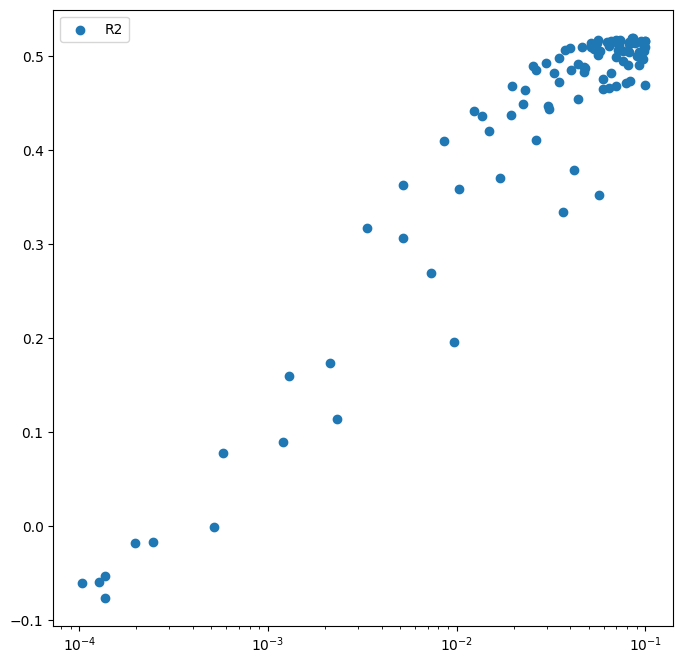

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(df_sort.params_learning_rate.values,df_sort.value.values,label='R2')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

In [15]:
import optuna
def objective(trial):
    param = {
        'iterations':trial.suggest_int("iterations", 700, 1200, step=100),
        'learning_rate': trial.suggest_float("learning_rate",0.05, 1,log=True),
        'depth':trial.suggest_int("depth", 6, 14, step=2),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-6, 1.0, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]), 
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]), 
        'random_strength':trial.suggest_float("random_strength", 1e-6, 5.0, log=True),
        'leaf_estimation_method':trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        'score_function':trial.suggest_categorical("score_function", ["L2", "Cosine"]),
        'early_stopping_rounds':20,
        'eval_metric':'R2',
        'rsm':trial.suggest_float("rsm", 0.1, 1.0, log=True)
    }
    if param["bootstrap_type"] == "Bayesian": 
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10) 
    elif param["bootstrap_type"] == "Bernoulli": 
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1) 
    
    cat_model = cat.CatBoostRegressor(**param)

    r2 = cross_val_score(cat_model, x, y, n_jobs=-1, cv=5, scoring="r2").mean()
    
    return r2

study = optuna.create_study(
    direction="maximize",
    study_name="catboost_parameter_opt",
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

study.optimize(objective, n_trials=100)
df = study.trials_dataframe()
df
df.to_csv(r'C:\Users\19189\Desktop\Morgan_cat_trial2.csv',index=False)

D:\anaconda3\envs\CATMOS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-04-19 23:05:26,090] A new study created in memory with name: catboost_parameter_opt
[I 2024-04-19 23:07:27,017] Trial 0 finished with value: 0.44815513227056075 and parameters: {'iterations': 900, 'learning_rate': 0.372750385629242, 'depth': 8, 'l2_leaf_reg': 1.2519898030349943e-06, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'random_strength': 1.1171279750319596, 'leaf_estimation_method': 'Newton', 'score_function': 'L2', 'rsm': 0.3464760123760657}. Best is trial 0 with value: 0.44815513227056075.
[I 2024-04-19 23:09:42,672] Trial 1 finished with value: 0.45758192015122584 and parameters: {'iterations': 1000, 'learning_rate': 0.09493359047073192, 'depth': 8, 'l2_leaf_reg': 0.010023593633298473, 'boosting_type': 'Ordered', 'b

In [16]:
df2=pd.read_csv(r'C:\Users\19189\Desktop\Morgan_cat_trial2.csv')
df2

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_random_strength,params_rsm,params_score_function,params_subsample,state
0,0,0.448155,2024-04-19 23:05:26.092894,2024-04-19 23:07:27.016436,0 days 00:02:00.923542,NaN,Ordered,MVS,8,900,0.000001,Newton,0.372750,1.117128,0.346476,L2,NaN,COMPLETE
1,1,0.457582,2024-04-19 23:07:27.018455,2024-04-19 23:09:42.672612,0 days 00:02:15.654157,NaN,Ordered,MVS,8,1000,0.010024,Newton,0.094934,0.000056,0.853748,Cosine,NaN,COMPLETE
2,2,0.477419,2024-04-19 23:09:42.675023,2024-04-20 01:06:43.212928,0 days 01:57:00.537905,NaN,Ordered,Bernoulli,14,1000,0.000002,Newton,0.077572,0.001037,0.361336,Cosine,0.483937,COMPLETE
3,3,0.489650,2024-04-20 01:06:43.214900,2024-04-20 01:12:14.242011,0 days 00:05:31.027111,8.802630,Plain,Bayesian,12,1100,0.002766,Gradient,0.053238,0.000901,0.317374,Cosine,NaN,COMPLETE
4,4,0.452119,2024-04-20 01:12:14.243097,2024-04-20 01:13:26.129586,0 days 00:01:11.886489,7.684150,Plain,Bayesian,10,700,0.073349,Gradient,0.051260,0.006346,0.331412,L2,NaN,COMPLETE
5,5,0.464288,2024-04-20 01:13:26.130588,2024-04-20 01:38:34.197139,0 days 00:25:08.066551,NaN,Ordered,Bernoulli,12,800,0.002218,Gradient,0.313258,0.000508,0.494178,L2,0.861946,COMPLETE
6,6,0.413517,2024-04-20 01:38:34.197139,2024-04-20 01:39:18.848008,0 days 00:00:44.650869,NaN,Ordered,MVS,6,900,0.226678,Newton,0.457274,0.000011,0.447327,Cosine,NaN,COMPLETE
7,7,0.492594,2024-04-20 01:39:18.851627,2024-04-20 01:48:18.308033,0 days 00:08:59.456406,NaN,Ordered,Bernoulli,10,1100,0.000067,Newton,0.162059,0.000028,0.452091,L2,0.665373,COMPLETE
8,8,0.478380,2024-04-20 01:48:18.308033,2024-04-20 03:39:40.663514,0 days 01:51:22.355481,NaN,Ordered,MVS,14,900,0.000034,Newton,0.086625,0.000008,0.332591,Cosine,NaN,COMPLETE
9,9,0.450544,2024-04-20 03:39:40.664530,2024-04-20 03:40:27.880100,0 days 00:00:47.215570,NaN,Ordered,MVS,6,1000,0.071948,Gradient,0.094181,0.000006,0.770222,Cosine,NaN,COMPLETE


In [17]:
df_sort=df2.sort_values(by='value',ascending=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_sort

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_random_strength,params_rsm,params_score_function,params_subsample,state
86,86,0.520918,2024-04-20 09:40:33.913484,2024-04-20 09:42:39.629997,0 days 00:02:05.716513,NaN,Plain,Bernoulli,10,1200,0.212640,Gradient,0.078346,0.006502,0.754172,Cosine,0.692685,COMPLETE
87,87,0.520787,2024-04-20 09:42:39.630998,2024-04-20 09:44:42.984772,0 days 00:02:03.353774,NaN,Plain,Bernoulli,10,1200,0.212190,Gradient,0.083044,0.000785,0.799697,Cosine,0.697674,COMPLETE
69,69,0.519758,2024-04-20 09:00:47.508989,2024-04-20 09:05:52.739012,0 days 00:05:05.230023,NaN,Plain,Bernoulli,12,1100,0.070072,Gradient,0.070973,0.002888,0.307042,Cosine,0.606632,COMPLETE
98,98,0.518778,2024-04-20 10:12:16.113077,2024-04-20 10:14:14.203438,0 days 00:01:58.090361,NaN,Plain,Bernoulli,10,1200,0.056303,Gradient,0.066225,0.000471,0.566355,Cosine,0.628651,COMPLETE
54,54,0.518678,2024-04-20 08:19:39.868651,2024-04-20 08:21:15.440246,0 days 00:01:35.571595,NaN,Plain,Bernoulli,10,900,0.021320,Newton,0.113176,0.000005,0.731286,Cosine,0.897796,COMPLETE
43,43,0.517560,2024-04-20 06:55:00.018082,2024-04-20 07:00:01.853871,0 days 00:05:01.835789,NaN,Plain,MVS,12,1000,0.349049,Gradient,0.107316,0.012665,0.405385,Cosine,NaN,COMPLETE
82,82,0.517330,2024-04-20 09:34:19.276893,2024-04-20 09:36:06.228248,0 days 00:01:46.951355,NaN,Plain,Bernoulli,10,1100,0.107325,Gradient,0.079135,0.000705,0.490609,Cosine,0.611113,COMPLETE
71,71,0.517075,2024-04-20 09:07:38.091685,2024-04-20 09:09:20.021447,0 days 00:01:41.929762,NaN,Plain,Bernoulli,10,1100,0.070024,Gradient,0.070543,0.000555,0.298346,Cosine,0.625682,COMPLETE
84,84,0.516649,2024-04-20 09:38:00.857682,2024-04-20 09:39:56.252322,0 days 00:01:55.394640,NaN,Plain,Bernoulli,10,1200,0.106937,Gradient,0.063315,0.001397,0.450316,Cosine,0.644905,COMPLETE
76,76,0.516528,2024-04-20 09:16:09.903134,2024-04-20 09:18:00.767417,0 days 00:01:50.864283,NaN,Plain,Bernoulli,10,1100,0.505707,Gradient,0.079652,0.003356,0.516278,Cosine,0.635775,COMPLETE


In [18]:
d=df_sort.iloc[0]
row=d.to_dict()
row

{'number': 86,
 'value': 0.5209181079722749,
 'datetime_start': '2024-04-20 09:40:33.913484',
 'datetime_complete': '2024-04-20 09:42:39.629997',
 'duration': '0 days 00:02:05.716513',
 'params_bagging_temperature': nan,
 'params_boosting_type': 'Plain',
 'params_bootstrap_type': 'Bernoulli',
 'params_depth': 10,
 'params_iterations': 1200,
 'params_l2_leaf_reg': 0.2126401036375577,
 'params_leaf_estimation_method': 'Gradient',
 'params_learning_rate': 0.0783456753220752,
 'params_random_strength': 0.0065022422458716,
 'params_rsm': 0.7541723390342481,
 'params_score_function': 'Cosine',
 'params_subsample': 0.6926851907717733,
 'state': 'COMPLETE'}